<a href="https://colab.research.google.com/github/hyetae/2023-graduate/blob/main/Finish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setting

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab.patches import cv2_imshow
import numpy as np
import cv2
import matplotlib.pyplot as plt

#Logic...
##1. 핵 찾기(이때 size 조절)
##2. 핵 주변의 색 분포 파악
##3. 세포가 한 개만 있으면 세포질을 찾아 bounding box 그리기
##4. 세포가 여러 개 있으면 핵 주변만 morphology 진행
##5. 2번으로 돌아가 반복

In [139]:
def find_contours(img, size):
  RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  gray = cv2.cvtColor(RGB, cv2.COLOR_RGB2GRAY)
  res, thr = cv2.threshold(gray, size, 255, cv2.THRESH_BINARY)
  contours, _ = cv2.findContours(thr, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  
  ct = []
  for i in range(len(contours[:]) - 2):
    cnt = contours[i+1]
    x, y, w, h = cv2.boundingRect(cnt)
    if w+h < 80:
      continue
    else:
      ct.append(cnt)
  
  return ct

In [140]:
def color_distribution(img):
  colors = ['b', 'g', 'r']
  bgr_planes = cv2.split(img)
  global blue

  for (p, c) in zip(bgr_planes, colors):
    if c == 'b':
      blue = cv2.calcHist([p], [0], None, [256], [0, 256])
    hist = cv2.calcHist([p], [0], None, [256], [0, 256])

  tmp1 = blue[195].tolist()
  tmp2 = int(tmp1[0])
  return tmp2

In [141]:
def draw_bb(img, contours):
  for i in range(len(contours[:]) - 1):
    cnt = contours[i]
    x, y, w, h = cv2.boundingRect(cnt)
    cv2.rectangle(img, (x, y), (x+w, y+h), (0,0,255), 3)

  cv2_imshow(img)

In [142]:
def erode(img):
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
  erosion = cv2.erode(img,kernel,iterations=2)
  return erosion

In [143]:
def dilate(img):
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
  dilation = cv2.dilate(img,kernel,iterations=3)
  return dilation

In [144]:
def find_cells(img):

  img_copy = img.copy()

  isTrue = True

  #핵 주변 색 분포 파악
  while(isTrue):

    #핵 찾기
    contours = find_contours(img, 100)

    #핵 주변 찾기
    for i in range(len(contours) - 1):
      cnt = contours[i]
      x, y, w, h = cv2.boundingRect(cnt)
      img_cut = img_copy[y-h:y+2*h, x-w:x+2*w]

      #색 분포 정상
      if color_distribution(img_cut) < 300:
          isTrue = False

      #색 분포 비정상
      else:
        isTrue = True
        img_copy[y-h:y+2*h, x-w:x+2*w] = erode(dilate(img_cut))

  #세포질 찾기
  contours = find_contours(img_copy, 190)

  #바운딩 박스 그리기
  draw_bb(img, contours)

In [149]:
def main():
  img = cv2.imread('/content/drive/MyDrive/cell-data/dense.jpeg')
  find_cells(img)

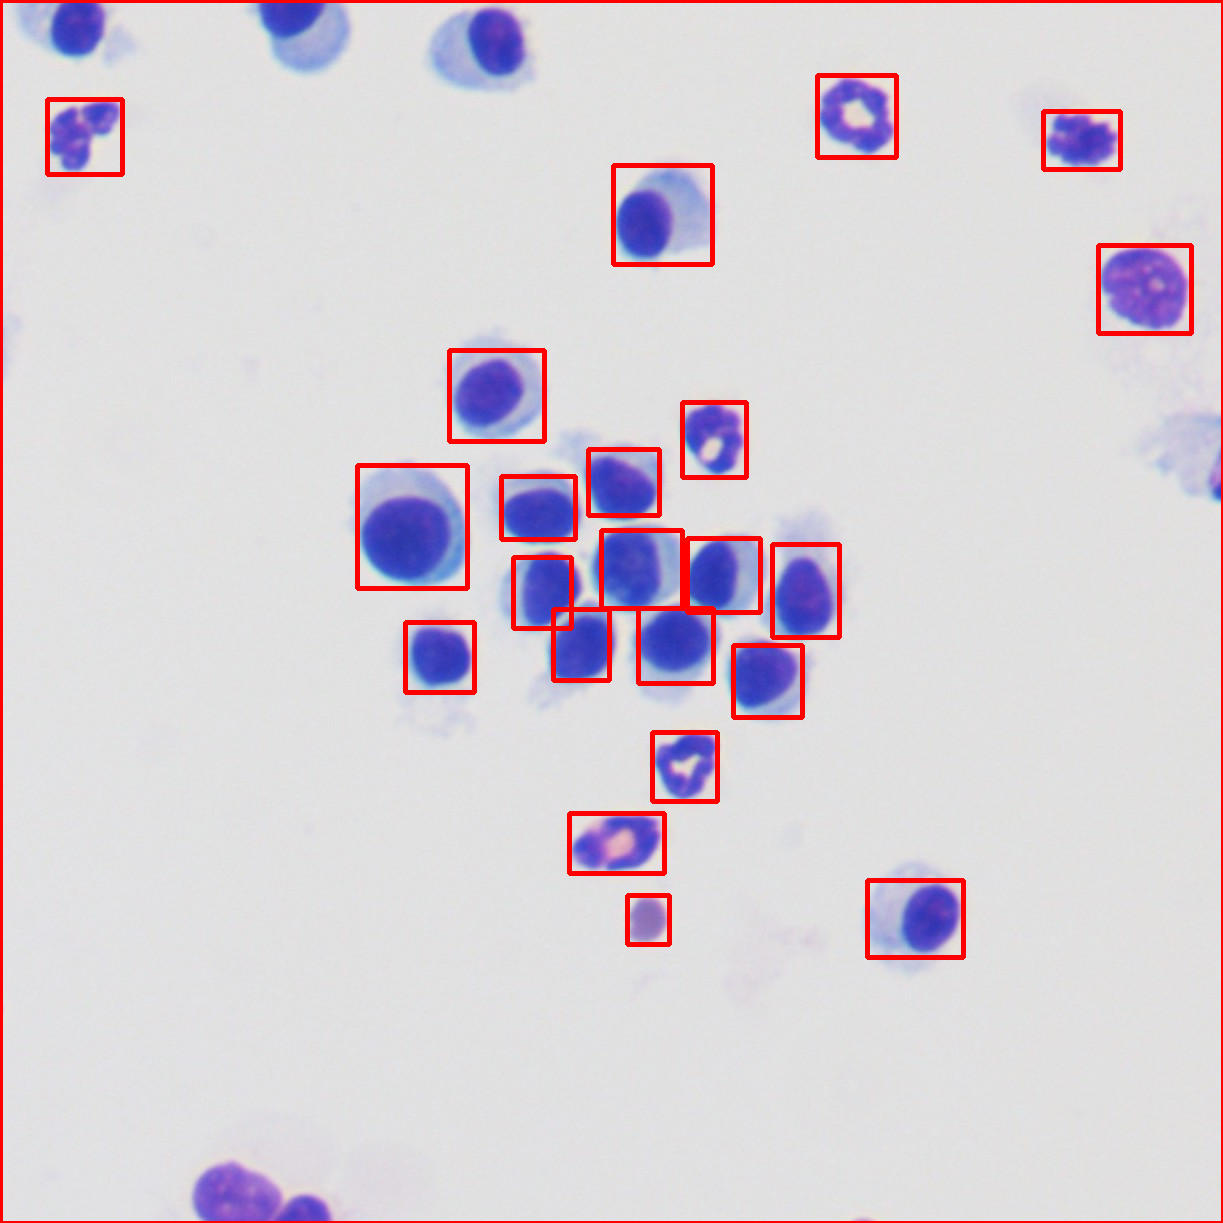

In [150]:
if __name__ == "__main__":
	main()

#Contrast

In [158]:
def img_contrast(img):
  lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
  l, a, b = cv2.split(lab)

  clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
  cl = clahe.apply(l)

  limg = cv2.merge((cl, a, b))
  bgr = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

  return bgr

In [179]:
def _color_distribution(img):
  colors = ['b', 'g', 'r']
  bgr_planes = cv2.split(img)
  global blue

  for (p, c) in zip(bgr_planes, colors):
    if c == 'b':
      blue = cv2.calcHist([p], [0], None, [256], [0, 256])
      cut = blue[220:230]
      m = cut.mean()
    hist = cv2.calcHist([p], [0], None, [256], [0, 256])

  return m

In [160]:
def _erode(img):
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
  erosion = cv2.erode(img,kernel,iterations=1)
  return erosion

def _dilate(img):
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
  dilation = cv2.dilate(img,kernel,iterations=2)
  return dilation

In [181]:
def _find_cells(img):

  img_copy = img.copy()

  isTrue = True

  #핵 주변 색 분포 파악
  while(isTrue):

    #핵 찾기
    contours = find_contours(img, 100)

    #핵 주변 찾기
    for i in range(len(contours) - 1):
      cnt = contours[i]
      x, y, w, h = cv2.boundingRect(cnt)
      img_cut = img_copy[y-h:y+2*h, x-w:x+2*w]

      #색 분포 정상
      if _color_distribution(img_cut) > 1800:
          isTrue = False

      #색 분포 비정상
      else:
        isTrue = True
        img_copy[y-h:y+2*h, x-w:x+2*w] = _erode(_dilate(img_cut))
      
  #세포질 찾기
  contours = find_contours(img_copy, 190)

  #바운딩 박스 그리기
  draw_bb(img, contours)

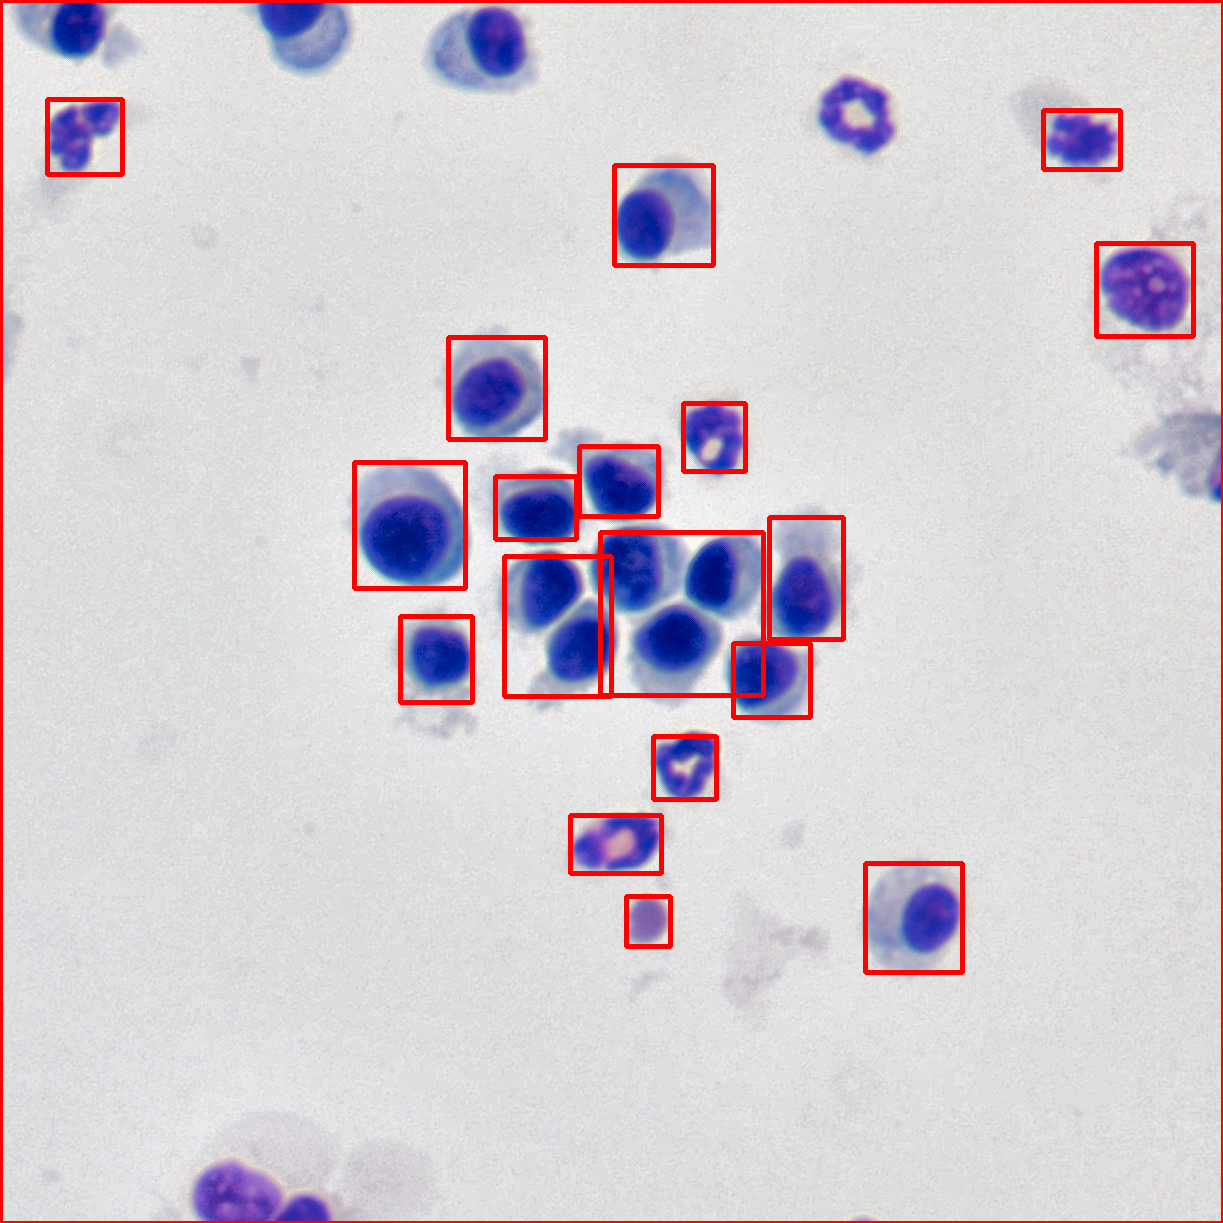

In [182]:
img = cv2.imread('/content/drive/MyDrive/cell-data/dense.jpeg')
contrast = img_contrast(img)
_find_cells(contrast)